In [1]:
import sys
sys.path.insert(0, '../../..')
from cgi import test
from multiprocessing.sharedctypes import Value
from yaml import parse
import glob
import warnings
import requests
import dateutil
import pytz
import traceback
import pandas            as pd
import pandas_ta         as ta
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import mlfinlab          as fml
from   mlfinlab          import sample_weights
import pyfolio           as pf
from scipy.stats         import norm
from backtesting         import Backtest, Strategy
from backtesting.lib     import crossover

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (20,12)

/home/sharav/src/portfolio-xm/env/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
import pickle

with open('ret_sr_list.pickle', 'rb') as f:
    ret_sr_loaded = pickle.load(f)

ret_sr_loaded

[(EntryTime
  2017-08-22 13:02:00+00:00    0.017221
  2017-09-02 14:42:00+00:00    0.024158
  2017-09-03 13:51:00+00:00    0.020012
  2017-09-04 18:48:00+00:00   -0.026377
  2017-09-05 02:03:00+00:00    0.043378
                                 ...   
  2018-03-29 20:12:00+00:00   -0.016299
  2018-03-29 21:12:00+00:00   -0.017635
  2018-03-30 00:42:00+00:00   -0.021068
  2018-03-31 05:37:00+00:00    0.035437
  2018-03-31 20:32:00+00:00   -0.026419
  Name: ReturnPct, Length: 302, dtype: float64,
  0.8267180855601877),
 (EntryTime
  2018-04-01 13:27:00+00:00    0.021432
  2018-04-02 00:47:00+00:00    0.015632
  2018-04-02 11:17:00+00:00    0.023639
  2018-04-03 03:02:00+00:00   -0.015878
  2018-04-03 10:47:00+00:00    0.012198
                                 ...   
  2018-08-17 22:17:00+00:00   -0.009267
  2018-08-18 03:07:00+00:00    0.007963
  2018-08-18 07:07:00+00:00   -0.010315
  2018-08-19 11:12:00+00:00   -0.006355
  2018-08-20 16:42:00+00:00    0.005297
  Name: ReturnPct, Length

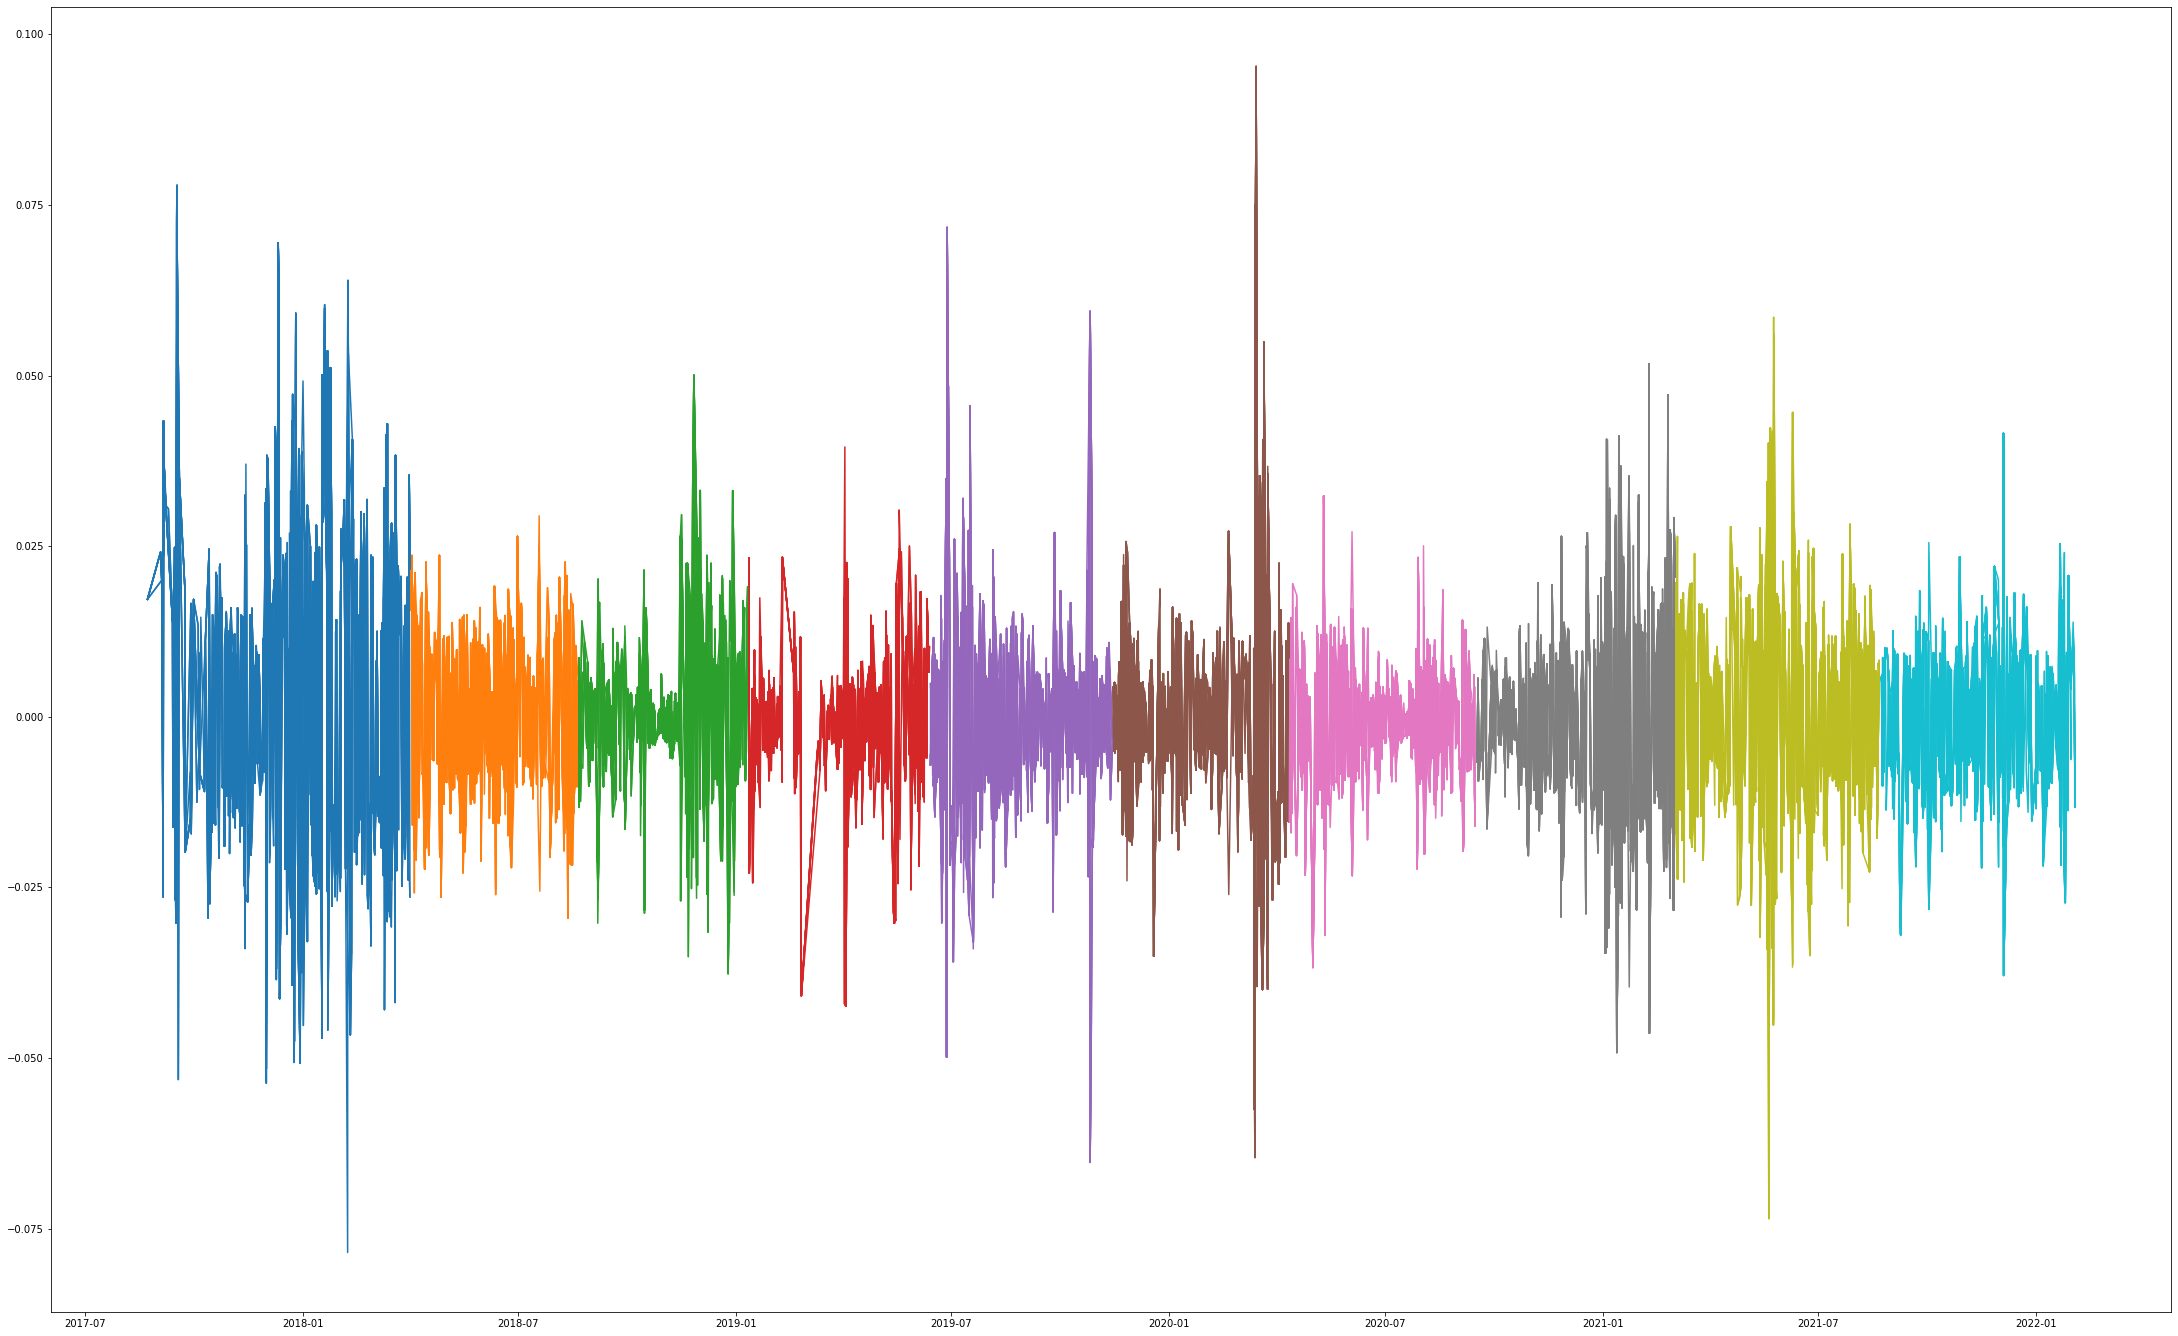

In [3]:
f, axs = plt.subplots(1, figsize=(38,24))
for item in ret_sr_loaded:
    temp_df = pd.DataFrame()
    temp_df['ret'   ] = item[0]
    axs.plot(temp_df['ret'])

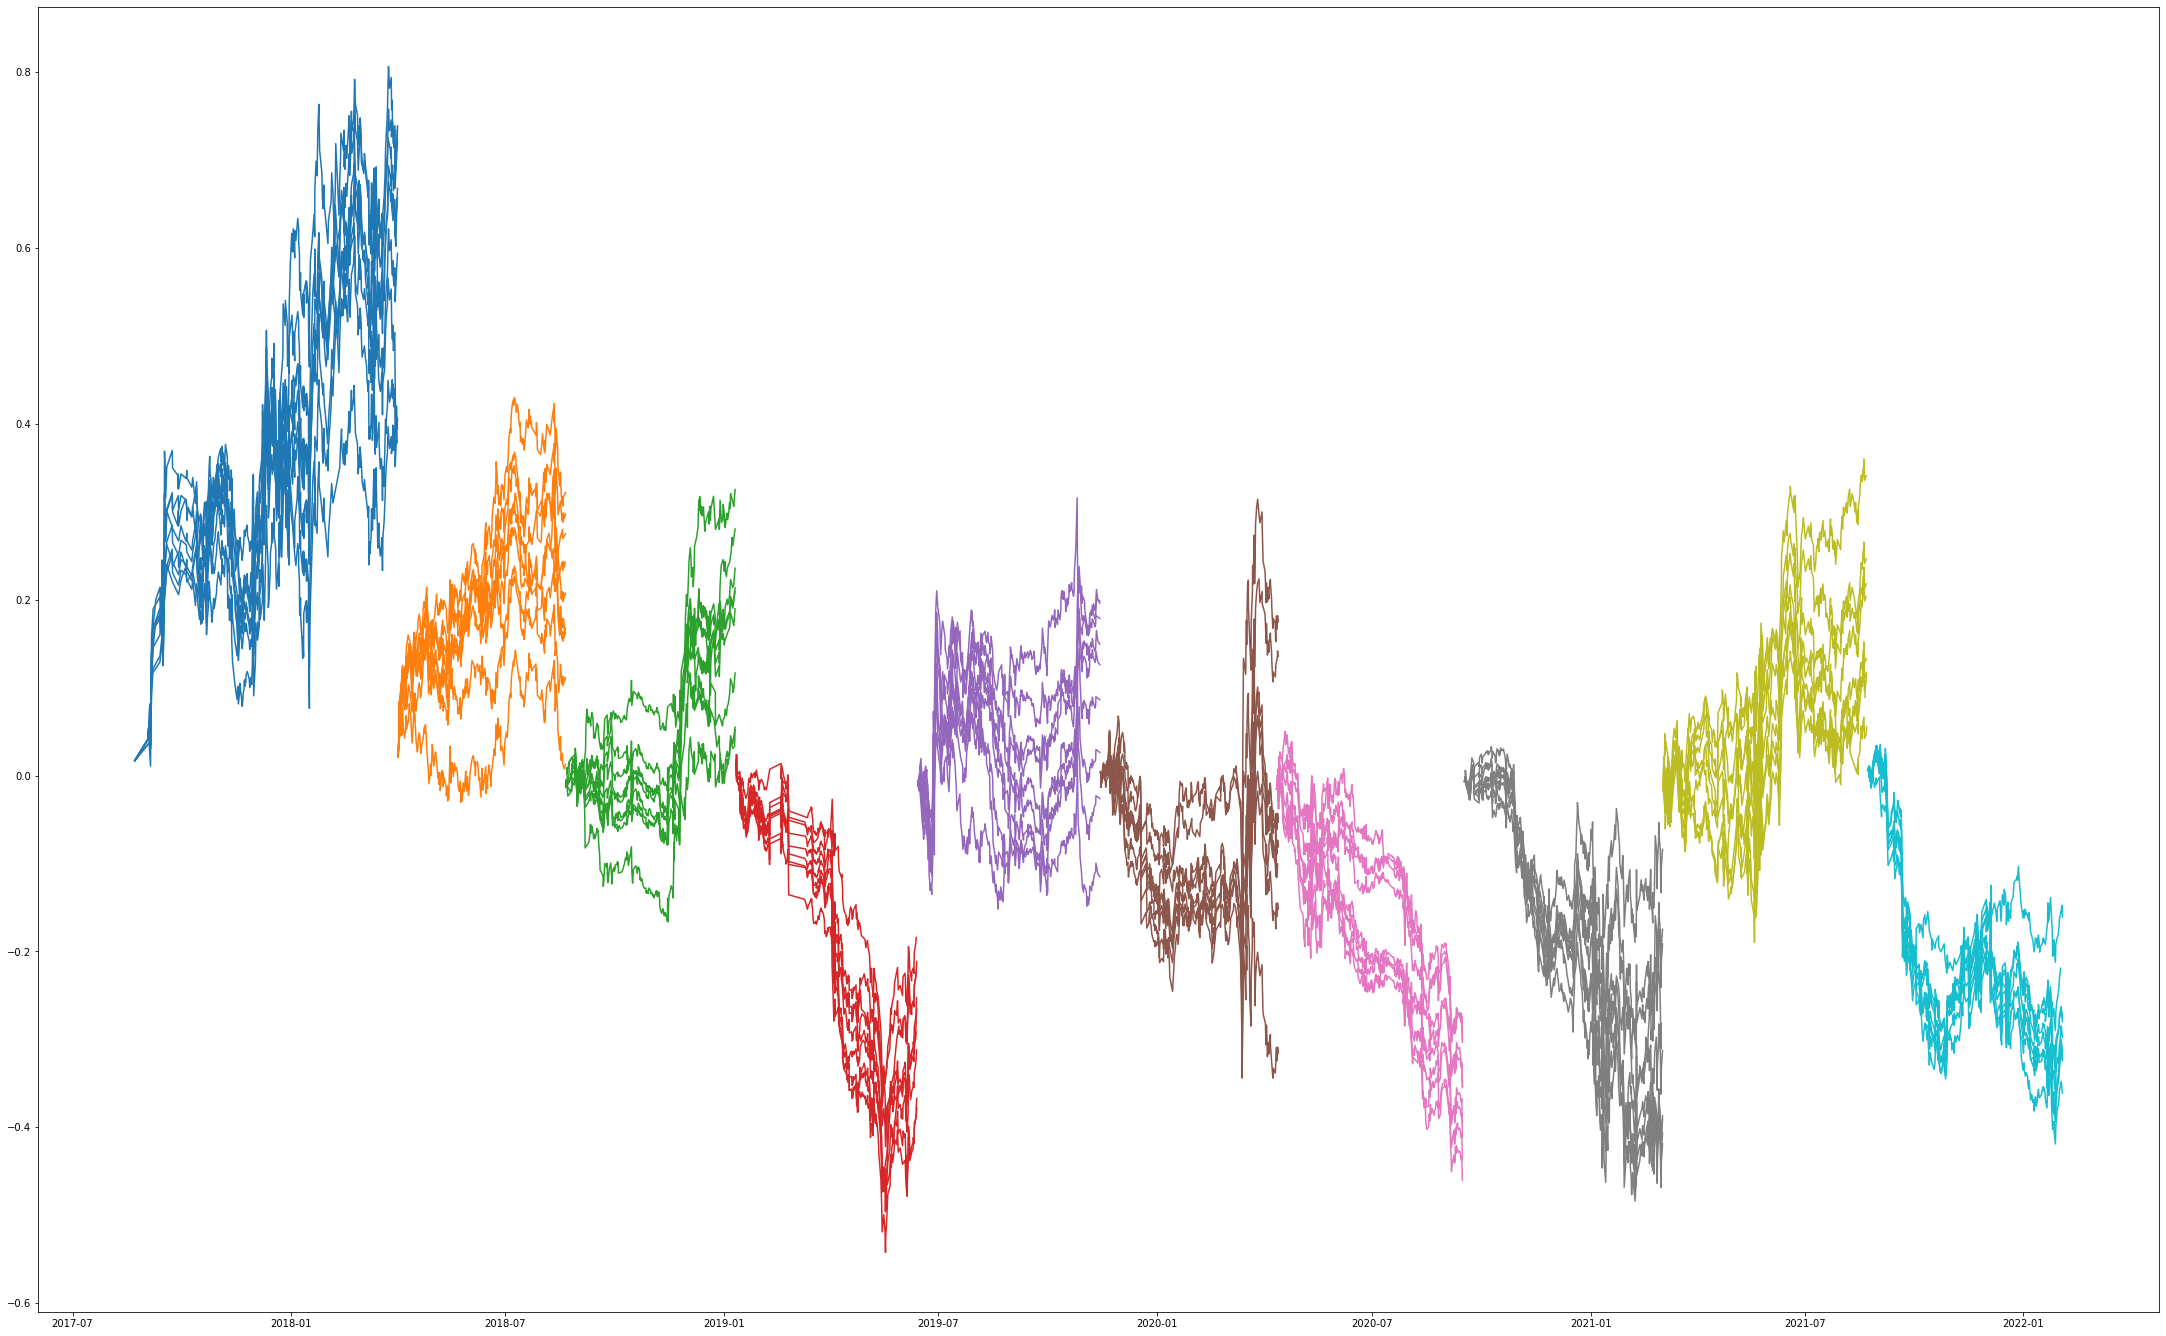

In [4]:
f, axs = plt.subplots(1, figsize=(38,24))
for item in ret_sr_loaded:
    temp_df = pd.DataFrame()
    temp_df['ret'   ] = item[0]
    temp_df['equity'] = temp_df['ret'].cumsum()
    axs.plot(temp_df['equity'])

In [5]:
import seaborn as sns

In [6]:
# functions for SR, PSR, DSR
#

import numpy as np
import pandas as pd
from scipy import stats as scipy_stats


def estimated_sharpe_ratio(returns):
    """
    Calculate the estimated sharpe ratio (risk_free=0).
    Parameters
    ----------
    returns: np.array, pd.Series, pd.DataFrame
    Returns
    -------
    float, pd.Series
    """
    return returns.mean() / returns.std(ddof=1)


def ann_estimated_sharpe_ratio(returns=None, periods=261, *, sr=None):
    """
    Calculate the annualized estimated sharpe ratio (risk_free=0).
    Parameters
    ----------
    returns: np.array, pd.Series, pd.DataFrame
    periods: int
        How many items in `returns` complete a Year.
        If returns are daily: 261, weekly: 52, monthly: 12, ...
    sr: float, np.array, pd.Series, pd.DataFrame
        Sharpe ratio to be annualized, it's frequency must be coherent with `periods`
    Returns
    -------
    float, pd.Series
    """
    if sr is None:
        sr = estimated_sharpe_ratio(returns)
    sr = sr * np.sqrt(periods)
    return sr


def estimated_sharpe_ratio_stdev(returns=None, *, n=None, skew=None, kurtosis=None, sr=None):
    """
    Calculate the standard deviation of the sharpe ratio estimation.
    Parameters
    ----------
    returns: np.array, pd.Series, pd.DataFrame
        If no `returns` are passed it is mandatory to pass the other 4 parameters.
    n: int
        Number of returns samples used for calculating `skew`, `kurtosis` and `sr`.
    skew: float, np.array, pd.Series, pd.DataFrame
        The third moment expressed in the same frequency as the other parameters.
        `skew`=0 for normal returns.
    kurtosis: float, np.array, pd.Series, pd.DataFrame
        The fourth moment expressed in the same frequency as the other parameters.
        `kurtosis`=3 for normal returns.
    sr: float, np.array, pd.Series, pd.DataFrame
        Sharpe ratio expressed in the same frequency as the other parameters.
    Returns
    -------
    float, pd.Series
    Notes
    -----
    This formula generalizes for both normal and non-normal returns.
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1821643
    """
    if type(returns) != pd.DataFrame:
        _returns = pd.DataFrame(returns)
    else:
        _returns = returns.copy()

    if n is None:
        n = len(_returns)
    if skew is None:
        skew = pd.Series(scipy_stats.skew(_returns), index=_returns.columns)
    if kurtosis is None:
        kurtosis = pd.Series(scipy_stats.kurtosis(_returns, fisher=False), index=_returns.columns)
    if sr is None:
        sr = estimated_sharpe_ratio(_returns)

    sr_std = np.sqrt((1 + (0.5 * sr ** 2) - (skew * sr) + (((kurtosis - 3) / 4) * sr ** 2)) / (n - 1))

    if type(returns) == pd.DataFrame:
        sr_std = pd.Series(sr_std, index=returns.columns)
    elif type(sr_std) not in (float, np.float64, pd.DataFrame):
        sr_std = sr_std.values[0]

    return sr_std


def probabilistic_sharpe_ratio(returns=None, sr_benchmark=0.0, *, sr=None, sr_std=None):
    """
    Calculate the Probabilistic Sharpe Ratio (PSR).
    Parameters
    ----------
    returns: np.array, pd.Series, pd.DataFrame
        If no `returns` are passed it is mandatory to pass a `sr` and `sr_std`.
    sr_benchmark: float
        Benchmark sharpe ratio expressed in the same frequency as the other parameters.
        By default set to zero (comparing against no investment skill).
    sr: float, np.array, pd.Series, pd.DataFrame
        Sharpe ratio expressed in the same frequency as the other parameters.
    sr_std: float, np.array, pd.Series, pd.DataFrame
        Standard deviation fo the Estimated sharpe ratio,
        expressed in the same frequency as the other parameters.
    Returns
    -------
    float, pd.Series
    Notes
    -----
    PSR(SR*) = probability that SR^ > SR*
    SR^ = sharpe ratio estimated with `returns`, or `sr`
    SR* = `sr_benchmark`
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1821643
    """
    if sr is None:
        sr = estimated_sharpe_ratio(returns)
    if sr_std is None:
        sr_std = estimated_sharpe_ratio_stdev(returns, sr=sr)

    psr = scipy_stats.norm.cdf((sr - sr_benchmark) / sr_std)

    if type(returns) == pd.DataFrame:
        psr = pd.Series(psr, index=returns.columns)
    elif type(psr) not in (float, np.float64):
        psr = psr[0]

    return psr


def min_track_record_length(returns=None, sr_benchmark=0.0, prob=0.95, *, n=None, sr=None, sr_std=None):
    """
    Calculate the MIn Track Record Length (minTRL).
    Parameters
    ----------
    returns: np.array, pd.Series, pd.DataFrame
        If no `returns` are passed it is mandatory to pass a `sr` and `sr_std`.
    sr_benchmark: float
        Benchmark sharpe ratio expressed in the same frequency as the other parameters.
        By default set to zero (comparing against no investment skill).
    prob: float
        Confidence level used for calculating the minTRL.
        Between 0 and 1, by default=0.95
    n: int
        Number of returns samples used for calculating `sr` and `sr_std`.
    sr: float, np.array, pd.Series, pd.DataFrame
        Sharpe ratio expressed in the same frequency as the other parameters.
    sr_std: float, np.array, pd.Series, pd.DataFrame
        Standard deviation fo the Estimated sharpe ratio,
        expressed in the same frequency as the other parameters.
    Returns
    -------
    float, pd.Series
    Notes
    -----
    minTRL = minimum of returns/samples needed (with same SR and SR_STD) to accomplish a PSR(SR*) > `prob`
    PSR(SR*) = probability that SR^ > SR*
    SR^ = sharpe ratio estimated with `returns`, or `sr`
    SR* = `sr_benchmark`
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1821643
    """
    if n is None:
        n = len(returns)
    if sr is None:
        sr = estimated_sharpe_ratio(returns)
    if sr_std is None:
        sr_std = estimated_sharpe_ratio_stdev(returns, sr=sr)

    min_trl = 1 + (sr_std ** 2 * (n - 1)) * (scipy_stats.norm.ppf(prob) / (sr - sr_benchmark)) ** 2

    if type(returns) == pd.DataFrame:
        min_trl = pd.Series(min_trl, index=returns.columns)
    elif type(min_trl) not in (float, np.float64):
        min_trl = min_trl[0]

    return min_trl


def num_independent_trials(trials_returns=None, *, m=None, p=None):
    """
    Calculate the number of independent trials.
    
    Parameters
    ----------
    trials_returns: pd.DataFrame
        All trials returns, not only the independent trials.
        
    m: int
        Number of total trials.
        
    p: float
        Average correlation between all the trials.
    Returns
    -------
    int
    """
    if m is None:
        m = trials_returns.shape[1]
        
    if p is None:
        corr_matrix = trials_returns.corr()
        p = corr_matrix.values[np.triu_indices_from(corr_matrix.values,1)].mean()
        
    n = p + (1 - p) * m
    
    n = int(n)+1  # round up
    
    return n


def expected_maximum_sr(trials_returns=None, expected_mean_sr=0.0, *, independent_trials=None, trials_sr_std=None):
    """
    Compute the expected maximum Sharpe ratio (Analytically)
    
    Parameters
    ----------
    trials_returns: pd.DataFrame
        All trials returns, not only the independent trials.
        
    expected_mean_sr: float
        Expected mean SR, usually 0. We assume that random startegies will have a mean SR of 0,
        expressed in the same frequency as the other parameters.
        
    independent_trials: int
        Number of independent trials, must be between 1 and `trials_returns.shape[1]`
        
    trials_sr_std: float
        Standard deviation fo the Estimated sharpe ratios of all trials,
        expressed in the same frequency as the other parameters.
    Returns
    -------
    float
    """
    emc = 0.5772156649 # Euler-Mascheroni constant
    
    if independent_trials is None:
        independent_trials = num_independent_trials(trials_returns)
    
    if trials_sr_std is None:
        srs = estimated_sharpe_ratio(trials_returns)
        trials_sr_std = srs.std()
    
    maxZ = (1 - emc) * scipy_stats.norm.ppf(1 - 1./independent_trials) + emc * scipy_stats.norm.ppf(1 - 1./(independent_trials * np.e))
    expected_max_sr = expected_mean_sr + (trials_sr_std * maxZ)
    
    return expected_max_sr


def deflated_sharpe_ratio(trials_returns=None, returns_selected=None, expected_mean_sr=0.0, *, expected_max_sr=None):
    """
    Calculate the Deflated Sharpe Ratio (PSR).
    Parameters
    ----------
    trials_returns: pd.DataFrame
        All trials returns, not only the independent trials.
        
    returns_selected: pd.Series
    expected_mean_sr: float
        Expected mean SR, usually 0. We assume that random startegies will have a mean SR of 0,
        expressed in the same frequency as the other parameters.
        
    expected_max_sr: float
        The expected maximum sharpe ratio expected after running all the trials,
        expressed in the same frequency as the other parameters.
    Returns
    -------
    float
    Notes
    -----
    DFS = PSR(SR⁰) = probability that SR^ > SR⁰
    SR^ = sharpe ratio estimated with `returns`, or `sr`
    SR⁰ = `max_expected_sr`
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2460551
    """
    if expected_max_sr is None:
        expected_max_sr = expected_maximum_sr(trials_returns, expected_mean_sr)
        
    dsr = probabilistic_sharpe_ratio(returns=returns_selected, sr_benchmark=expected_max_sr)

    return dsr

In [7]:
returns_df = pd.DataFrame()

for idx, item in enumerate(ret_sr_loaded):
    temp_df = pd.DataFrame()
    temp_df['ret'] = item[0]
    temp_df.index = range(len(temp_df.index))
    returns_df[idx] = temp_df['ret']

returns_df

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,0.017221,0.021432,-0.013205,0.017846,-0.007032,-0.004056,-0.015440,-0.006632,-0.017080,0.005169,...,0.017221,0.021432,-0.013205,0.023278,-0.007032,-0.004967,-0.015440,-0.006632,-0.017080,0.005169
1,0.024158,0.015632,0.008643,-0.022893,-0.004906,-0.004179,0.007237,0.005631,0.026438,-0.007233,...,0.024158,0.015632,0.008643,-0.022893,-0.004906,0.005040,0.008478,0.005631,0.019153,-0.007233
2,0.020012,0.023639,-0.006388,-0.008310,0.007896,-0.004967,-0.006383,-0.009417,-0.023769,0.006147,...,0.020012,0.023639,-0.006388,-0.004612,0.007896,0.003255,0.007237,-0.005801,-0.023769,-0.008085
3,-0.026377,-0.015878,0.006495,0.004138,-0.010181,0.003415,-0.006259,-0.005513,-0.019876,-0.010123,...,-0.026377,0.023118,0.006495,0.004138,0.011611,0.004633,-0.006383,-0.004018,-0.019876,0.010127
4,0.043378,0.012198,0.005626,-0.005450,-0.009082,0.005040,-0.016968,-0.006240,0.014957,0.008648,...,0.043378,-0.015878,0.006138,-0.005450,-0.014632,0.002853,-0.006259,-0.005513,0.014957,0.009020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,-0.016299,NaN,NaN,NaN,NaN,NaN,-0.019645,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.006657,0.029184,NaN,NaN
298,-0.017635,NaN,NaN,NaN,NaN,NaN,-0.014649,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.008000,0.020465,NaN,NaN
299,-0.021068,NaN,NaN,NaN,NaN,NaN,0.012741,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.004811,NaN,NaN,NaN
300,0.035437,NaN,NaN,NaN,NaN,NaN,0.006285,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.006286,NaN,NaN,NaN


In [11]:
ann_best_srs = ann_estimated_sharpe_ratio(returns_df).sort_values(ascending=False)

ann_best_srs

22    1.990012
61    1.765678
11    1.750192
50    1.706921
12    1.687801
        ...   
76   -2.142625
53   -2.195599
6    -2.444914
26   -2.532995
16   -2.906279
Length: 90, dtype: float64

In [12]:
psr_list = probabilistic_sharpe_ratio(returns=returns_df, sr_benchmark=0).sort_values(ascending=False)

psr_list

60    0.951482
40    0.878720
30    0.876326
0     0.818676
54    0.723248
        ...   
84         NaN
85         NaN
87         NaN
88         NaN
89         NaN
Length: 90, dtype: float64

In [13]:
best_psr_name = probabilistic_sharpe_ratio(returns=returns_df, sr_benchmark=0).sort_values(ascending=False).index[0]

best_psr_name

60

<AxesSubplot:>

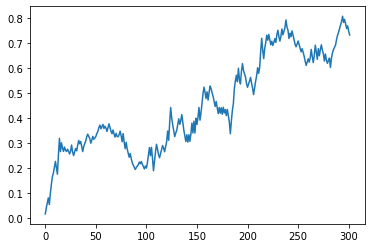

In [16]:
plot_df = pd.DataFrame()
plot_df['ret_pct'] = returns_df[best_psr_name]
plot_df['cum'    ] = plot_df['ret_pct'].cumsum()

plot_df['cum'].plot()

In [18]:
# Deflated Sharpe Ratio calculation
# We have only 3% chance that strategy have an edge can give us positive return in the future

best_psr_returns = returns_df[best_psr_name]

dsr = deflated_sharpe_ratio(trials_returns=returns_df, returns_selected=best_psr_returns)

print(f"Deflated Sharpe Ratio : {dsr}")

Deflated Sharpe Ratio : 0.030718291902341033


In [19]:
independent_trials = num_independent_trials(trials_returns=returns_df)

independent_trials

90

In [20]:
exp_max_sr = expected_maximum_sr(trials_returns=returns_df, independent_trials=independent_trials)

print(f"Expected maximum Sharpe Ratio : {exp_max_sr}")

Expected maximum Sharpe Ratio : 0.20171374177738374


In [21]:
dsr_2 = deflated_sharpe_ratio(returns_selected=best_psr_returns, expected_max_sr=exp_max_sr)

print(f"Another Deflated Sharpe Ration : {dsr_2}")

Another Deflated Sharpe Ration : 0.030718291902341033


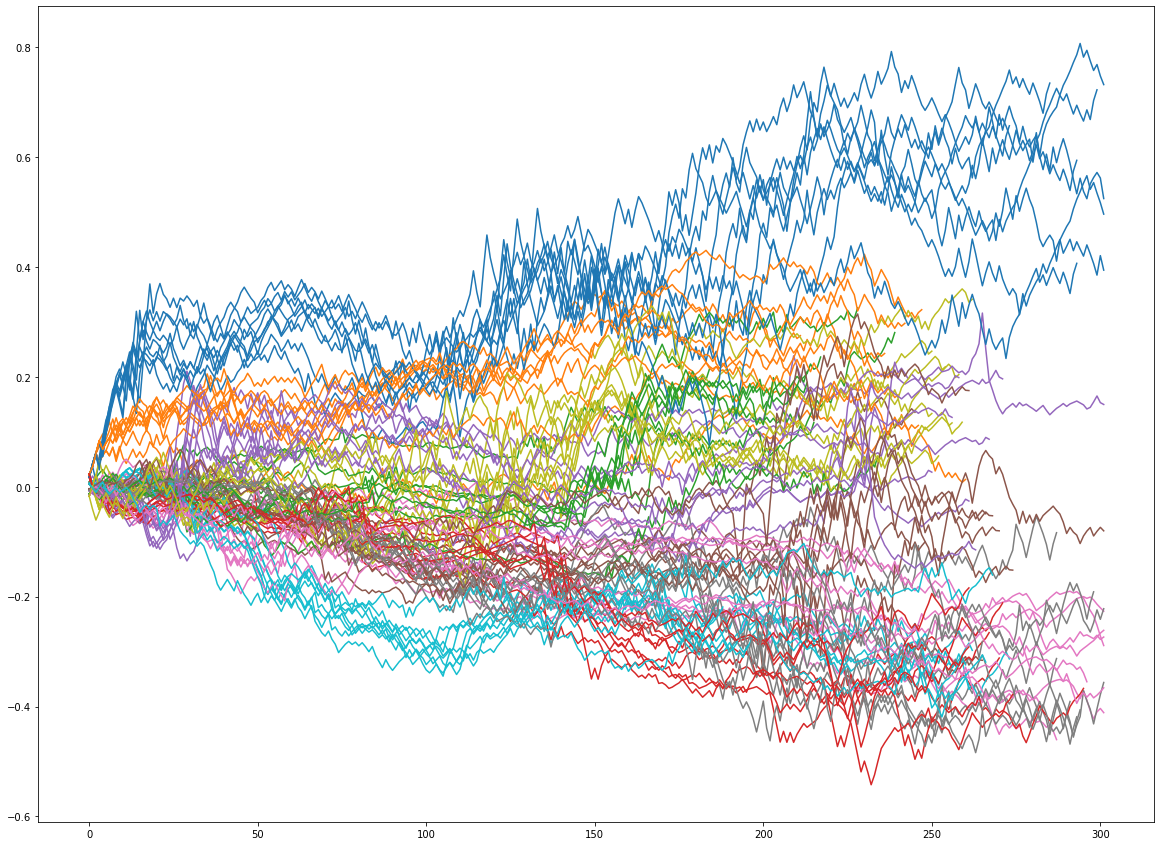

In [24]:
# Rendering multiple performances

f, axs = plt.subplots(1, figsize=(20,15))

cum_returns_df = pd.DataFrame()

for idx in range(0,len(returns_df.columns)):
    cum_returns_df[idx] = returns_df[idx].cumsum(0)

for idx in range(0,len(cum_returns_df.columns)):
    axs.plot(cum_returns_df[idx])

In [27]:
import scipy.stats as scipy_stats

def moments(returns):
    """
    Calculate the four moments: mean, std, skew, kurtosis.
    Parameters
    ----------
    returns: np.array, pd.Series, pd.DataFrame
    Returns
    -------
    pd.Series, pd.DataFrame
    """
    if type(returns) != pd.DataFrame:
        return pd.Series({'mean': np.mean(returns),
                          'std': np.std(returns, ddof=1),
                          'skew': scipy_stats.skew(returns),
                          'kurt': scipy_stats.kurtosis(returns, fisher=False)})
    else:
        return returns.apply(moments, axis=1)

<AxesSubplot:>

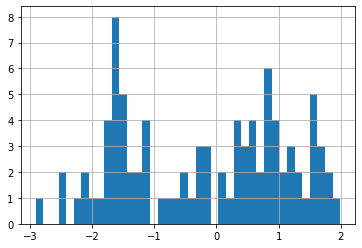

In [28]:
annualized_srs = ann_estimated_sharpe_ratio(returns_df)

annualized_srs.hist(bins=40)

In [29]:
moments(returns_df)

,mean,std,skew,kurt
0,0.001659,0.014114,0.165483,1.575590
1,0.003638,0.013853,-0.372445,2.341100
2,0.001659,0.013258,0.219582,2.264041
3,-0.001256,0.014349,0.174571,3.003503
4,0.001742,0.016405,0.787809,3.788196
...,...,...,...,...
297,-0.003689,0.016188,NaN,NaN
298,-0.000481,0.016901,NaN,NaN
299,0.004994,0.014926,NaN,NaN
300,-0.001662,0.017194,NaN,NaN
